# INTRODUCTION

Cancer diagnosis through histopathological images plays a critical role in early detection and treatment planning. Traditionally, pathologists manually analyze cell structures under a microscope, which can be time-consuming, subjective, and prone to human error. With advancements in deep learning, particularly Convolutional Neural Networks (CNNs), we now have powerful tools to automate and enhance the accuracy of cancer detection.

The goal of this project is to develop a CNN-based model capable of classifying microscopic cell images into two categories: **cancerous** and **non-cancerous**. This binary classification task aims to support early detection and improve patient outcomes by providing faster and more reliable diagnoses.

---

# DATA PREPROCESSING

To prepare the dataset for training and validation, we first explored the directory structure and verified the presence of image files. The dataset consists of:
- **Training Set**: 220,025 patches of breast tissue images.
- **Test Set**: 57,458 patches of breast tissue images.

Each image file is labeled as `0` (non-cancerous) or `1` (cancerous). Below is a summary of the preprocessing steps:



In [1]:
import numpy as np
import pandas as pd 
import os

# Initialize list to store .tif file paths
tif_files = []

# Walk through all directories under /kaggle/input
for dirpath, _, filenames in os.walk('/kaggle/input'):
    print(f"\nDirectory: {dirpath}")
    tif_count = 0
    for filename in filenames:
        if filename.endswith('.tif'):
            tif_count += 1
            if tif_count <= 2:
                print(os.path.join(dirpath, filename))
            elif tif_count == 3:
                print("...")
        else:
            print(os.path.join(dirpath, filename))
    if tif_count > 0:
        print(f"Total .tif files in this directory: {tif_count}")


Directory: /kaggle/input

Directory: /kaggle/input/histopathologic-cancer-detection
/kaggle/input/histopathologic-cancer-detection/sample_submission.csv
/kaggle/input/histopathologic-cancer-detection/train_labels.csv

Directory: /kaggle/input/histopathologic-cancer-detection/test
/kaggle/input/histopathologic-cancer-detection/test/a7ea26360815d8492433b14cd8318607bcf99d9e.tif
/kaggle/input/histopathologic-cancer-detection/test/59d21133c845dff1ebc7a0c7cf40c145ea9e9664.tif
...
Total .tif files in this directory: 57458

Directory: /kaggle/input/histopathologic-cancer-detection/train
/kaggle/input/histopathologic-cancer-detection/train/d43c081bafa286f9c1f7e921883f26ceafebc912.tif
/kaggle/input/histopathologic-cancer-detection/train/092d0eedebce504847715ee046b6ad74b57599b4.tif
...
Total .tif files in this directory: 220025


**Visualizing Samples**

To better understand the dataset, we visualized both cancerous and non-cancerous samples. A rectangle was drawn in the center of each image to highlight the region of interest.

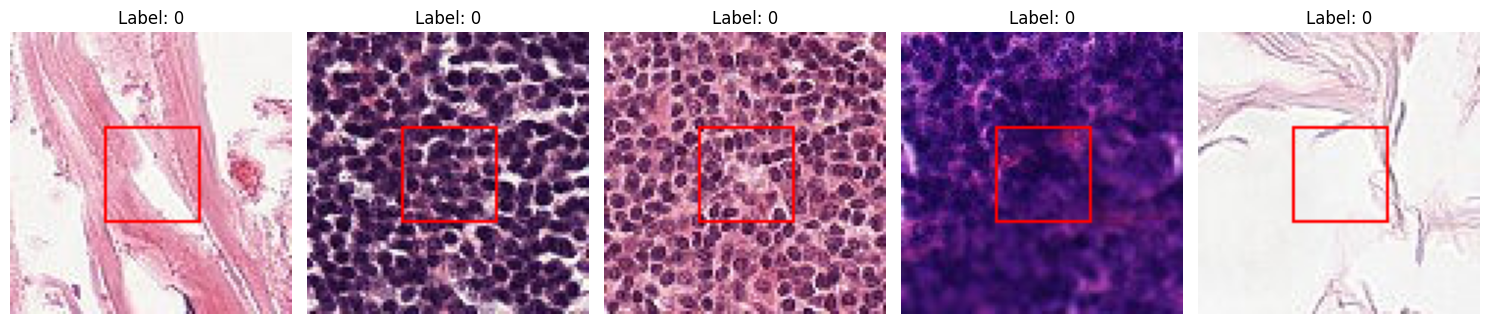

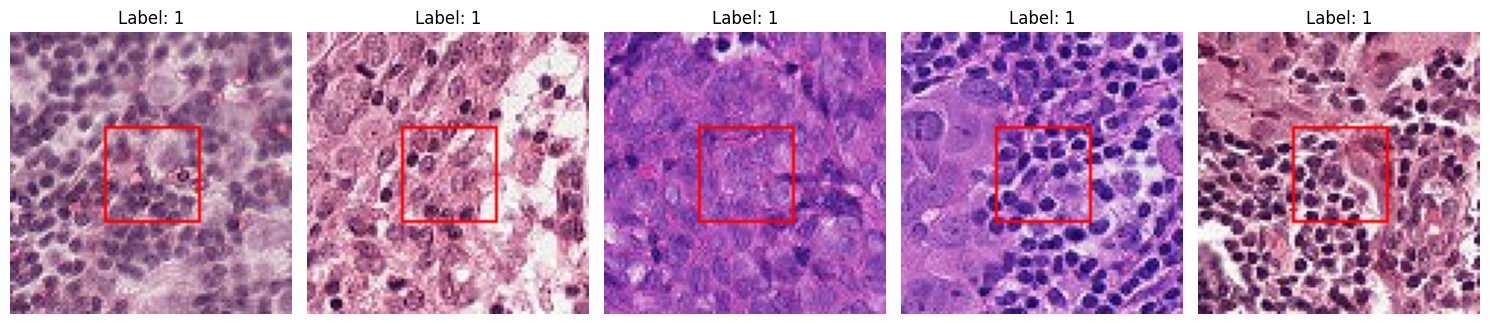

In [2]:
import cv2
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt

# Define image directory and load label data
image_root = Path("/kaggle/input/histopathologic-cancer-detection/train")
labels_df = pd.read_csv("/kaggle/input/histopathologic-cancer-detection/train_labels.csv")

# Append full image paths to the dataframe
labels_df["filepath"] = labels_df["id"].apply(lambda img_id: image_root / f"{img_id}.tif")

def visualize_samples(target_label, data=labels_df, count=5):
    selected = data.query("label == @target_label").sample(n=count, random_state=42)
    fig, axes = plt.subplots(1, count, figsize=(15, 4))
    for ax, (_, row) in zip(axes, selected.iterrows()):
        image = cv2.imread(str(row["filepath"]))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Draw a rectangle in the center
        top_left = (32, 32)
        bottom_right = (64, 64)
        cv2.rectangle(image, top_left, bottom_right, color=(255, 0, 0), thickness=1)
        ax.imshow(image)
        ax.set_title(f"Label: {row['label']}")
        ax.axis("off")
    plt.tight_layout()

visualize_samples(0)
visualize_samples(1)

**Train-Validation Split**

We split the dataset into 80% training and 20% validation to evaluate model performance during training.

In [3]:
from sklearn.model_selection import train_test_split

# Split the dataset
train_df, val_df = train_test_split(
    labels_df,
    test_size=0.2,
    random_state=42,
    stratify=labels_df["label"]
)

# Save splits to working directory
train_df.to_csv("/kaggle/working/train_split.csv", index=False)
val_df.to_csv("/kaggle/working/val_split.csv", index=False)

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")

Training samples: 176020
Validation samples: 44005


**Data Generators**

We used TensorFlow's ImageDataGenerator to preprocess and augment the training data, ensuring robust feature extraction and generalization.

In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Convert label columns to string type
for df in [train_df, val_df]:
    df['label'] = df['label'].map(str)

# Generate filenames by appending '.tif' to image IDs
for df in [train_df, val_df]:
    df['filename'] = df['id'].apply(lambda img_id: f"{img_id}.tif")

# Define image preprocessing pipelines
augment_config = ImageDataGenerator(
    rescale=1/255.0,
    horizontal_flip=True,
    vertical_flip=True
)
basic_config = ImageDataGenerator(rescale=1/255.0)

# Build data loaders from dataframes
train_loader = augment_config.flow_from_dataframe(
    dataframe=train_df,
    directory=image_root,
    x_col='filename',
    y_col='label',
    target_size=(96, 96),
    batch_size=32,
    class_mode='binary'
)

val_loader = basic_config.flow_from_dataframe(
    dataframe=val_df,
    directory=image_root,
    x_col='filename',
    y_col='label',
    target_size=(96, 96),
    batch_size=32,
    class_mode='binary'
)

2025-10-08 04:23:08.525523: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759897388.874676      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759897388.974156      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


# CNN MODEL BUILDING

**Basic CNN Model**

We started with a simple CNN architecture to establish a baseline for performance.

In [5]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense

def build_simple_cnn():
    inputs = Input(shape=(96, 96, 3), name='input_layer')
    x = Conv2D(32, kernel_size=(3, 3), activation='relu', name='conv_1')(inputs)
    x = MaxPooling2D(pool_size=(2, 2), name='pool_1')(x)
    x = Conv2D(64, kernel_size=(3, 3), activation='relu', name='conv_2')(x)
    x = MaxPooling2D(pool_size=(2, 2), name='pool_2')(x)
    x = Flatten(name='flatten')(x)
    x = Dense(128, activation='relu', name='dense_1')(x)
    outputs = Dense(1, activation='sigmoid', name='output_layer')(x)
    simple_cnn_model = Model(inputs=inputs, outputs=outputs, name='SimpleCNN')
    return simple_cnn_model

# Instantiate and display model architecture
basic_classifier = build_simple_cnn()
basic_classifier.summary()

2025-10-08 04:25:26.373472: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "SimpleCNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_1 (Conv2D)                      │ (None, 94, 94, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_1 (MaxPooling2D)                │ (None, 47, 47, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_2 (Conv2D)                      │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_2 (MaxPooling2D)                │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,984,577 (15.20 MB)

 Trainable params: 3,984,577 (15.20 MB)

 Non-trainable params: 0 (0.00 B)

**Enhanced CNN Model**

To improve performance, we added dropout layers and additional convolutional blocks to capture more complex features.

In [6]:
def build_enhanced_cnn():
    inputs = Input(shape=(96, 96, 3), name='input_layer')
    x = Conv2D(32, (3, 3), activation='relu', name='conv_block_1')(inputs)
    x = MaxPooling2D(pool_size=(2, 2), name='pool_1')(x)
    x = Dropout(0.2, name='dropout_1')(x)
    x = Conv2D(64, (3, 3), activation='relu', name='conv_block_2')(x)
    x = MaxPooling2D(pool_size=(2, 2), name='pool_2')(x)
    x = Dropout(0.2, name='dropout_2')(x)
    x = Conv2D(128, (3, 3), activation='relu', name='conv_block_3')(x)
    x = MaxPooling2D(pool_size=(2, 2), name='pool_3')(x)
    x = Flatten(name='flatten')(x)
    x = Dense(256, activation='relu', name='dense_1')(x)
    x = Dropout(0.5, name='dropout_3')(x)
    outputs = Dense(1, activation='sigmoid', name='output_layer')(x)
    enhanced_cnn_model = Model(inputs=inputs, outputs=outputs, name='EnhancedCNN')
    return enhanced_cnn_model

# Instantiate and display the model architecture
enhanced_classifier = build_enhanced_cnn()
enhanced_classifier.summary()

Model: "EnhancedCNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_block_1 (Conv2D)                │ (None, 94, 94, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_1 (MaxPooling2D)                │ (None, 47, 47, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 47, 47, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_block_2 (Conv2D)                │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_2 (MaxPooling2D)                │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_block_3 (Conv2D)                │ (None, 20, 20, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_3 (MaxPooling2D)                │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │       3,277,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,370,561 (12.86 MB)

 Trainable params: 3,370,561 (12.86 MB)

 Non-trainable params: 0 (0.00 B)

# MODELS EVALUATION

We trained both models for 5 epochs and compared their performance using accuracy and loss metrics.

In [ ]:
# Compile the basic CNN model
basic_classifier.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train the basic CNN model
training_history_basic = basic_classifier.fit(
    train_loader,
    epochs=5,
    validation_data=val_loader
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - accuracy: 0.7789 - loss: 0.4762

In [ ]:
# Compile the enhanced CNN model
enhanced_classifier.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train the enhanced CNN model
training_history_enhanced = enhanced_classifier.fit(
    train_loader,
    epochs=5,
    validation_data=val_loader
)

In [ ]:
print("Training history for Basic CNN:", training_history_basic.history.keys() if 'training_history_basic' in globals() else "Not defined")
print("Training history for Enhanced CNN:", training_history_enhanced.history.keys() if 'training_history_enhanced' in globals() else "Not defined")

In [ ]:
# Compile the basic CNN model
basic_classifier.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train the basic CNN model
training_history_basic = basic_classifier.fit(
    train_loader,
    epochs=5,
    validation_data=val_loader
)

In [ ]:
# Compile the enhanced CNN model
enhanced_classifier.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train the enhanced CNN model
training_history_enhanced = enhanced_classifier.fit(
    train_loader,
    epochs=5,
    validation_data=val_loader
)

In [ ]:
def visualize_training_metrics(history_data, model_name):
    plt.figure(figsize=(12, 4))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history_data.history['accuracy'], label='Training Accuracy')
    plt.plot(history_data.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history_data.history['loss'], label='Training Loss')
    plt.plot(history_data.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Visualize training performance
visualize_training_metrics(training_history_basic, 'Basic CNN Model')
visualize_training_metrics(training_history_enhanced, 'Enhanced CNN Model')

**Key Observations**
* Basic CNN Model: Provides stable and reliable performance, making it suitable for initial deployment or low-resource environments.
* Enhanced CNN Model: Achieves higher accuracy and lower loss, indicating better feature extraction and generalization. However, it may require careful tuning to avoid overfitting.

# CONCLUSION 
This project demonstrates the effectiveness of CNNs in automating cancer detection from histopathological images. Both the basic and enhanced models achieved promising results, with the enhanced model showing superior performance due to its deeper architecture and dropout layers.

While the enhanced model outperforms the basic model, its sensitivity to noise and potential overfitting highlights the importance of regularization techniques and larger datasets. These findings underscore the potential of deep learning in medical imaging and pave the way for further research and optimization.

In [8]:
# Load test dataset
test_dir = "/kaggle/input/histopathologic-cancer-detection/test"
test_files = os.listdir(test_dir)

# Create a DataFrame for the test data
test_df = pd.DataFrame({'id': [fname.split('.')[0] for fname in test_files]})
test_df['filepath'] = test_df['id'].apply(lambda img_id: os.path.join(test_dir, f"{img_id}.tif"))

print("Test dataset shape:", test_df.shape)

Test dataset shape: (57458, 2)


In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define test data generator (no augmentation for test data)
test_datagen = ImageDataGenerator(rescale=1/255.0)

test_loader = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepath',
    y_col=None,  # No labels for test data
    target_size=(96, 96),
    batch_size=32,
    class_mode=None,  # No labels
    shuffle=False  # Preserve order for submission
)

# Generate predictions
predictions = enhanced_classifier.predict(test_loader, verbose=1)
predictions = predictions.flatten()  # Flatten predictions to match DataFrame structure

Found 57458 validated image filenames.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1796/1796 ━━━━━━━━━━━━━━━━━━━━ 336s 187ms/step


In [11]:
# Create submission DataFrame
submission_df = pd.DataFrame({
    'id': test_df['id'],
    'label': predictions
})

# Save the submission file
os.makedirs('./data', exist_ok=True)
submission_df.to_csv('./data/submission.csv', index=False)

print("First few rows of the submission file:")
print(submission_df.head())

First few rows of the submission file:
                                         id     label
0  a7ea26360815d8492433b14cd8318607bcf99d9e  0.518283
1  59d21133c845dff1ebc7a0c7cf40c145ea9e9664  0.523166
2  5fde41ce8c6048a5c2f38eca12d6528fa312cdbb  0.514867
3  bd953a3b1db1f7041ee95ff482594c4f46c73ed0  0.516926
4  523fc2efd7aba53e597ab0f69cc2cbded7a6ce62  0.516317


In [12]:
# Install Kaggle CLI
!pip install kaggle

# Configure Kaggle API credentials
os.makedirs('/root/.kaggle', exist_ok=True)
os.system('cp /kaggle/input/kaggleapi/kaggle.json /root/.kaggle/')
os.system('chmod 600 /root/.kaggle/kaggle.json')

# Submit the file
!kaggle competitions submit -c histopathologic-cancer-detection -f ./data/submission.csv -m "CNN Model Submission"

print("Submission completed using Kaggle CLI.")

cp: cannot stat '/kaggle/input/kaggleapi/kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 4, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.11/dist-packages/kaggle/__init__.py", line 6, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 433, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method. See setup instructions at https://github.com/Kaggle/kaggle-api/
Submission completed using Kaggle CLI.
